In [70]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [71]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [81]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print "Training examples summary:"
display.display(training_examples.describe())
print "Validation examples summary:"
display.display(validation_examples.describe())

print "Training targets summary:"
display.display(training_targets.describe())
print "Validation targets summary:"
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,latitude_32_to_33,latitude_33_to_34
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2657.4,541.1,1432.9,502.9,3.9,1.9,1.0,1.0
std,2.1,2.0,12.6,2213.4,423.5,1132.2,386.5,1.9,0.6,0.0,0.0
min,32.5,-124.3,1.0,2.0,2.0,3.0,2.0,0.5,0.1,1.0,1.0
25%,33.9,-121.8,18.0,1466.0,297.0,794.0,282.0,2.6,1.5,1.0,1.0
50%,34.2,-118.5,29.0,2129.0,434.0,1168.0,410.0,3.6,1.9,1.0,1.0
75%,37.7,-118.0,37.0,3157.2,651.0,1720.0,607.0,4.8,2.3,1.0,1.0
max,42.0,-114.3,52.0,37937.0,6445.0,28566.0,6082.0,15.0,4.0,1.0,1.0


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,latitude_32_to_33,latitude_33_to_34
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.5,2610.7,535.3,1421.7,497.1,3.9,1.9,1.0,1.0
std,2.1,2.0,12.5,2097.2,416.6,1184.6,379.6,1.9,0.6,0.0,0.0
min,32.5,-124.3,2.0,8.0,1.0,9.0,1.0,0.5,0.0,1.0,1.0
25%,33.9,-121.8,18.0,1450.2,296.0,777.0,281.0,2.6,1.5,1.0,1.0
50%,34.2,-118.5,29.0,2125.0,433.0,1165.0,407.0,3.5,1.9,1.0,1.0
75%,37.7,-118.0,37.0,3135.2,644.0,1724.2,600.0,4.8,2.3,1.0,1.0
max,41.9,-114.6,52.0,30405.0,4952.0,35682.0,4769.0,15.0,4.0,1.0,1.0


Training targets summary:


,median_house_value
count,12000.0
mean,195.2
std,92.0
min,15.0
25%,118.9
50%,179.7
75%,264.3
max,350.0


Validation targets summary:


,median_house_value
count,5000.0
mean,196.5
std,92.8
min,15.0
25%,121.2
50%,181.3
75%,266.1
max,350.0


In [82]:
correlation_dataframe = training_examples.copy()
correlation_dataframe["target"] = training_targets["median_house_value"]

correlation_dataframe.corr()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,latitude_32_to_33,latitude_33_to_34,target
latitude,1.0,-0.9,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,0.2,nan,nan,-0.2
longitude,-0.9,1.0,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.1,nan,nan,-0.0
housing_median_age,0.0,-0.1,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,-0.1,nan,nan,0.1
total_rooms,-0.0,0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.2,nan,nan,0.2
total_bedrooms,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.1,nan,nan,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...
median_income,-0.1,-0.0,-0.1,0.2,-0.0,0.0,0.0,1.0,0.5,nan,nan,0.7
rooms_per_person,0.2,-0.1,-0.1,0.2,0.1,-0.2,0.0,0.5,1.0,nan,nan,0.4
latitude_32_to_33,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
latitude_33_to_34,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [74]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [75]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [77]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
    
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "RMSE (on training data):"
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, training_root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print "Model training finished."

  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

In [76]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
#   processed_features['median_income'] = processed_features['median_income'].apply(lambda x: min(x, 9))
  processed_features['rooms_per_person'] = processed_features['rooms_per_person'].apply(lambda x: min(x, 4))
  processed_features.describe()
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  output_targets["median_house_value"] = output_targets["median_house_value"].apply(lambda x: min(x, 350))
  return output_targets

In [78]:
correlation_dataframe.corr()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,target
latitude,1.0,-0.9,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,0.1,-0.1
longitude,-0.9,1.0,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.1,-0.0
housing_median_age,0.0,-0.1,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,-0.1,0.1
total_rooms,-0.0,0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.1,0.1
population,-0.1,0.1,-0.3,0.9,0.9,1.0,0.9,0.0,-0.1,-0.0
households,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,0.0,-0.0,0.1
median_income,-0.1,-0.0,-0.1,0.2,-0.0,0.0,0.0,1.0,0.2,0.7
rooms_per_person,0.1,-0.1,-0.1,0.1,0.1,-0.1,-0.0,0.2,1.0,0.2
target,-0.1,-0.0,0.1,0.1,0.1,-0.0,0.1,0.7,0.2,1.0


In [79]:
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2657.4,541.1,1432.9,502.9,3.9,2.0
std,2.1,2.0,12.6,2213.4,423.5,1132.2,386.5,1.9,1.1
min,32.5,-124.3,1.0,2.0,2.0,3.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1466.0,297.0,794.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2129.0,434.0,1168.0,410.0,3.6,1.9
75%,37.7,-118.0,37.0,3157.2,651.0,1720.0,607.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,28566.0,6082.0,15.0,52.0


Training model...
RMSE (on training data):
  period 00 : 214.74
  period 01 : 213.66
  period 02 : 212.58
  period 03 : 211.50
  period 04 : 210.42
  period 05 : 209.34
  period 06 : 208.26
  period 07 : 207.19
  period 08 : 206.11
  period 09 : 205.04
Model training finished.


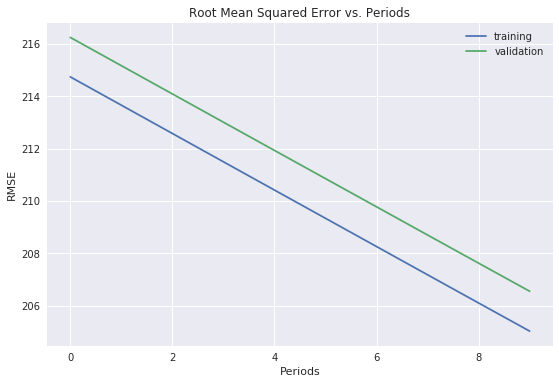

In [83]:
minimal_features = ['median_income', 'latitude_32_to_33', 'latitude_33_to_34']

assert minimal_features, "You must select at least one feature!"

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

#
# Don't forget to adjust these parameters.
#
train_model(
    learning_rate=0.001,
    steps=500,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

In [ ]:
minimal_training_examples.describe()

In [84]:
LATITUDE_RANGES = zip(xrange(32, 44), xrange(33, 45))

def select_and_transform_features(source_df):
  selected_examples = pd.DataFrame()
  selected_examples["median_income"] = source_df["median_income"]
  for r in LATITUDE_RANGES:
    selected_examples["latitude_%d_to_%d" % r] = source_df["latitude"].apply(
      lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0)
  return selected_examples

selected_training_examples = select_and_transform_features(training_examples)
selected_validation_examples = select_and_transform_features(validation_examples)

In [85]:
selected_validation_examples.describe()

,median_income,latitude_32_to_33,latitude_33_to_34,latitude_34_to_35,latitude_35_to_36,latitude_36_to_37,latitude_37_to_38,latitude_38_to_39,latitude_39_to_40,latitude_40_to_41,latitude_41_to_42,latitude_42_to_43,latitude_43_to_44
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,3.9,0.1,0.2,0.3,0.0,0.1,0.2,0.1,0.0,0.0,0.0,0.0,0.0
std,1.9,0.2,0.4,0.4,0.2,0.2,0.4,0.3,0.2,0.1,0.1,0.0,0.0
min,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,4.8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,15.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [86]:
selected_training_examples.describe()

,median_income,latitude_32_to_33,latitude_33_to_34,latitude_34_to_35,latitude_35_to_36,latitude_36_to_37,latitude_37_to_38,latitude_38_to_39,latitude_39_to_40,latitude_40_to_41,latitude_41_to_42,latitude_42_to_43,latitude_43_to_44
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,3.9,0.1,0.2,0.2,0.0,0.1,0.2,0.1,0.0,0.0,0.0,0.0,0.0
std,1.9,0.2,0.4,0.4,0.2,0.2,0.4,0.3,0.2,0.1,0.1,0.0,0.0
min,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,3.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,4.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,15.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


Training model...
RMSE (on training data):
  period 00 : 195.25
  period 01 : 175.05
  period 02 : 155.32
  period 03 : 136.29
  period 04 : 118.37
  period 05 : 102.01
  period 06 : 89.64
  period 07 : 80.32
  period 08 : 75.38
  period 09 : 73.58
Model training finished.


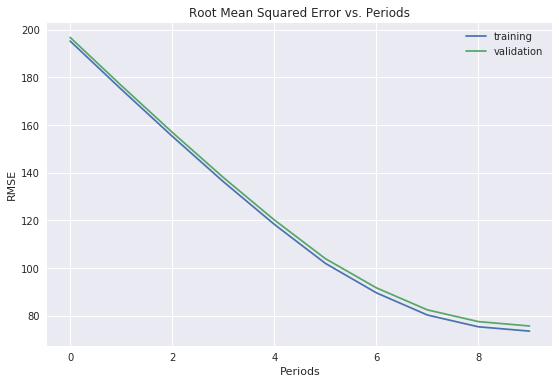

In [89]:
linear_regressor = train_model(
    learning_rate=0.02,
    steps=500,
    batch_size=5,
    training_examples=selected_training_examples,
    training_targets=training_targets,
    validation_examples=selected_validation_examples,
    validation_targets=validation_targets)

In [91]:
california_housing_test_data = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_test_input_fn = lambda: my_input_fn(
      select_and_transform_features(test_examples), 
      test_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print "Final RMSE (on test data): %0.2f" % root_mean_squared_error

Final RMSE (on test data): 75.16


Training model...
RMSE (on training data):
  period 00 : 185.07
  period 01 : 155.29
  period 02 : 127.16
  period 03 : 101.94
  period 04 : 82.63
  period 05 : 75.14
  period 06 : 73.06
  period 07 : 72.70
  period 08 : 72.51
  period 09 : 72.62
Model training finished.


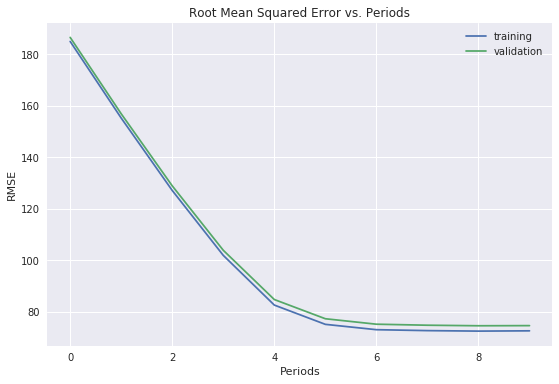

In [92]:
linear_regressor = train_model(
    learning_rate=0.03,
    steps=500,
    batch_size=5,
    training_examples=selected_training_examples,
    training_targets=training_targets,
    validation_examples=selected_validation_examples,
    validation_targets=validation_targets)

In [93]:
california_housing_test_data = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_test_input_fn = lambda: my_input_fn(
      select_and_transform_features(test_examples), 
      test_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print "Final RMSE (on test data): %0.2f" % root_mean_squared_error

Final RMSE (on test data): 73.63
